In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sqlite3 as lite
import sys
from pyne import nucname
import pandas as pd
import pickle
from pyne.material import Material
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn import svm
import pickle

/home/teddy/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: QAWarning: pyne.data is not yet QA compliant.
  return f(*args, **kwds)
/home/teddy/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: QAWarning: pyne.material is not yet QA compliant.
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
# get sqlite cursor
df = pd.read_csv('./curated.csv', index_col=0)
df = df.loc[df['reactor_type'] == 'PWR']

# Finding the Average Assembly and its Composition 

In [3]:
avg_burnup = df['bu'].mean()
avg_enrichment = df['init_enr'].mean()
print('AVG BURNUP: %f MWD/MTHM \nAVG ENRICHMENT: %f wt%% U235' %(avg_burnup, avg_enrichment))

AVG BURNUP: 39686.442086 MWD/MTHM 
AVG ENRICHMENT: 3.724495 wt% U235


In [4]:
# average assembly composition
df['err'] = abs(df['bu'] - avg_burnup) + abs(df['init_enr'] - avg_enrichment) * 10000
minimum_err = df['err'].argmin()
df = df.drop(columns='err')
average_assem = df.loc[minimum_err]
print(average_assem)

reactor_type               PWR
total_mass                 462
evaluation_date     2002-09-29
init_enr                  3.72
bu                       39676
zr-95              0.000101925
zr-93                0.0928857
ra-226             6.77283e-12
ru-103             5.78308e-06
ru-106              0.00797625
sb-124             7.91346e-08
sb-125             0.000970126
pu-238               0.0267678
pu-239                0.692696
np-237               0.0593706
nb-95              0.000120217
pa-231             6.77701e-08
pd-107               0.0277255
pm-147               0.0143021
pu-240                0.262499
pu-241                0.166991
pu-244             4.42209e-06
pu-242               0.0620735
i-129                0.0188063
h-3                6.20193e-06
kr-85               0.00262086
nb-94              1.69758e-07
cm-248             4.68751e-08
cs-134               0.0111718
cs-135               0.0629654
                      ...     
eu-154              0.00323369
eu-155  

/home/teddy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  This is separate from the ipykernel package so we can avoid doing imports until


In [5]:
# get isotope dictionary
avg_recipe = average_assem.iloc[5:].to_dict()
for iso, comp in avg_recipe.items():
    print(iso, comp)

zr-95 0.0001019249329
zr-93 0.0928857316017
ra-226 6.77282792208e-12
ru-103 5.78308290043e-06
ru-106 0.00797625281385
sb-124 7.91346298701e-08
sb-125 0.000970125562771
pu-238 0.0267677813853
pu-239 0.692696082251
np-237 0.0593706190476
nb-95 0.000120216619048
pa-231 6.77700562771e-08
pd-107 0.0277254502165
pm-147 0.014302097619
pu-240 0.262498917749
pu-241 0.166991058442
pu-244 4.42208744589e-06
pu-242 0.0620735497835
i-129 0.0188063062771
h-3 6.20193008658e-06
kr-85 0.00262085541126
nb-94 1.69758335498e-07
cm-248 4.68751147186e-08
cs-134 0.0111717688312
cs-135 0.0629653831169
cm-245 0.000472016471861
cm-244 0.00641943528139
cm-246 4.21448268398e-05
cm-247 6.41546385281e-07
eu-152 2.16631948052e-06
cs-137 0.139044917749
eu-154 0.00323369458874
eu-155 0.000888663354978
am-241 0.0161663393939
am-242m 0.000125440151515
am-243 0.0165889136364
cf-251 1.05420876623e-10
cf-249 4.22029112554e-10
ag-108m 2.49213809524e-08
ag-110m 3.42195714286e-05
ac-227 2.78803419913e-12
cm-243 5.82710324675e-

# We store all the assemblies in a dictionary, one with the composition with UNF-ST&DARDS, and the other with recipe composition

In [6]:
iso_list = list(df)[5:]
iso_list

['zr-95',
 'zr-93',
 'ra-226',
 'ru-103',
 'ru-106',
 'sb-124',
 'sb-125',
 'pu-238',
 'pu-239',
 'np-237',
 'nb-95',
 'pa-231',
 'pd-107',
 'pm-147',
 'pu-240',
 'pu-241',
 'pu-244',
 'pu-242',
 'i-129',
 'h-3',
 'kr-85',
 'nb-94',
 'cm-248',
 'cs-134',
 'cs-135',
 'cm-245',
 'cm-244',
 'cm-246',
 'cm-247',
 'eu-152',
 'cs-137',
 'eu-154',
 'eu-155',
 'am-241',
 'am-242m',
 'am-243',
 'cf-251',
 'cf-249',
 'ag-108m',
 'ag-110m',
 'ac-227',
 'cm-243',
 'cm-242',
 'c-14',
 'ce-144',
 'u-234',
 'u-235',
 'u-236',
 'y-90',
 'u-238',
 'th-229',
 'tc-99',
 'sm-151',
 'se-79',
 'sr-90',
 'sn-126',
 'th-232',
 'th-230',
 'u-232',
 'u-233',
 'other']

In [8]:
model_dict = pickle.load(open('./script/ann_model.pkl', 'rb'))
model_dict

{'model': <keras.engine.sequential.Sequential at 0x7efff650fa58>,
 'xscaler': MinMaxScaler(copy=True, feature_range=(0, 1)),
 'yscaler': MinMaxScaler(copy=True, feature_range=(0, 1)),
 'iso_list': ['zr-95',
  'zr-93',
  'ra-226',
  'ru-103',
  'ru-106',
  'sb-124',
  'sb-125',
  'pu-238',
  'pu-239',
  'np-237',
  'nb-95',
  'pa-231',
  'pd-107',
  'pm-147',
  'pu-240',
  'pu-241',
  'pu-244',
  'pu-242',
  'i-129',
  'h-3',
  'kr-85',
  'nb-94',
  'cm-248',
  'cs-134',
  'cs-135',
  'cm-245',
  'cm-244',
  'cm-246',
  'cm-247',
  'eu-152',
  'cs-137',
  'eu-154',
  'eu-155',
  'am-241',
  'am-242m',
  'am-243',
  'cf-251',
  'cf-249',
  'ag-108m',
  'ag-110m',
  'ac-227',
  'cm-243',
  'cm-242',
  'c-14',
  'ce-144',
  'u-234',
  'u-235',
  'u-236',
  'y-90',
  'u-238',
  'th-229',
  'tc-99',
  'sm-151',
  'se-79',
  'sr-90',
  'sn-126',
  'th-232',
  'th-230',
  'u-232',
  'u-233',
  'other']}

In [ ]:
def get_a(f):
    z = ''
    for i in f:
        if i.isdigit():
            z += i
    return int(z)


def predict(model_dict, enr_bu):
        model = model_dict['model']
        xscaler = model_dict['xscaler']
        yscaler = model_dict['yscaler']
        iso_list = model_dict['iso_list']
        x = xscaler.transform(enr_bu)
        y = yscaler.inverse_transform(model.predict(x))[0]
        comp_dict = {}
        for indx, iso in enumerate(iso_list):
            comp_dict[iso] = y[indx]
        return comp_dict

In [ ]:
def get_lump_recipe_rom_dict(df, model_dict):
    lump_dict = {}
    recipe_dict = {}
    rom_dict = {}
    for index, row in df.iterrows():
        eval_date = row['evaluation_date']
        if eval_date not in lump_dict.keys():
            rom_dict[eval_date] = {}
            lump_dict[eval_date] = {}
            recipe_dict[eval_date] = {}
            lump_dict[eval_date]['mass'] = row['total_mass']
            lump_dict[eval_date]['bu'] = row['bu']
            lump_dict[eval_date]['init_enr'] = row['init_enr']
            recipe_dict[eval_date]['mass'] = row['total_mass']
            rom_dict[eval_date]['mass'] = row['total_mass']
            lump_dict[eval_date]['comp'] = {}
            rom_dict[eval_date]['comp'] = {}

            enr_bu = [[row['init_enr'], row['bu']]]
            rom_dict[eval_date]['enr_bu'] = enr_bu
            rom_comp_dict = predict(model_dict, enr_bu)
            for iso in iso_list:
                lump_dict[eval_date]['comp'][iso] = row[iso] * 1e-2 * row['total_mass']
                # percentage to mass
                rom_dict[eval_date]['comp'][iso] = rom_comp_dict[iso] * 1e-2 * row['total_mass']
            recipe_dict[eval_date]['comp'] = avg_recipe
        else:
            lump_dict[eval_date]['mass'] += row['total_mass']
            rom_dict[eval_date]['mass'] += row['total_mass']
            enr_bu = [[row['init_enr'], row['bu']]]
            rom_comp_dict = predict(model_dict, enr_bu)
            for iso in iso_list:
                lump_dict[eval_date]['comp'][iso] += row[iso] * 1e-2 * row['total_mass']
                rom_dict[eval_date]['comp'][iso] += rom_comp_dict[iso] * 1e-2 * row['total_mass']
            recipe_dict[eval_date]['mass'] += row['total_mass']
        
    # normalize lump dict compositions
    for key, val in lump_dict.items():
        for key2, val2 in lump_dict[key]['comp'].items():
            lump_dict[key]['comp'][key2] = lump_dict[key]['comp'][key2] / val['mass']
            rom_dict[key]['comp'][key2] = rom_dict[key]['comp'][key2] / rom_dict[key]['mass']

    return lump_dict, recipe_dict, rom_dict

In [ ]:
# this takes a while:
lump_dict, recipe_dict, rom_dict = get_lump_recipe_rom_dict(df, model_dict)

In [ ]:
lump_dict2, recipe_dict2, rom_dict2 = lump_dict, recipe_dict, rom_dict

In [12]:
# change `others' to `h-1'
for key in lump_dict.keys():
    try:
        lump_dict2[key]['comp']['h-1'] = lump_dict2[key]['comp'].pop('other')
        rom_dict2[key]['comp']['h-1'] = rom_dict2[key]['comp'].pop('other')
        recipe_dict2[key]['comp']['h-1'] = recipe_dict2[key]['comp'].pop('other')
    except:
        print(key)

1993-09-25
1995-03-04
1996-09-15
1998-03-14
2001-03-04
1999-10-16
2002-10-06
2005-10-02
1996-03-10
1994-09-24
1999-03-28
2000-10-16
2002-02-24
2003-09-14
1997-10-12
1980-03-08
1981-11-07
1985-02-10
1984-01-14
1982-09-10
1987-10-03
1986-04-06
1990-09-22
1989-03-25
1983-10-22
1984-09-16
1986-01-05
1987-04-04
1988-10-02
1993-03-06
1990-03-24
1991-10-12
2000-03-27
2003-03-16
2006-04-02
2001-10-04
1988-10-03
1990-04-08
1993-02-15
1994-09-04
1996-04-01
1997-09-21
1999-03-14
2002-03-31
1989-02-20
2003-09-28
1994-03-19
1996-02-04
1997-03-16
1998-02-22
1999-09-19
2007-03-31
2008-09-29
1991-02-23
1992-10-17
1998-09-06
2013-10-06
2009-03-29
2007-09-30
1990-03-08
1992-03-16
1993-09-19
1995-03-19
1996-10-14
2000-10-02
2006-10-08
2011-04-03
2009-10-04
2001-04-01
2002-09-29
2011-10-02
1978-01-27
1979-02-02
1980-03-30
1982-01-02
1983-11-08
1985-10-12
1987-09-04
1989-08-28
1997-09-14
1982-03-28
1983-08-20
1991-10-01
1993-02-28
1994-09-07
1996-02-14
1984-09-26
1986-03-16
1987-06-13
1989-02-12
1990-09-25

In [13]:
f = open('lump_recipe_rom.pkl', 'wb')
pickle.dump([lump_dict, recipe_dict, rom_dict], f)
f.close()

## =======================================
## =======================================
## Pickled dictionary of all the dictionary of assemblies

In [9]:
comparison_list = pickle.load(open('./lump_recipe_rom.pkl',"rb"))
lump_dict = comparison_list[0]
recipe_dict = comparison_list[1]
rom_dict = comparison_list[2]

## Compare the difference between udb and rom results per assembly

In [10]:
for_plot = {'bu': [],
            'init_enr': [],
            'rmse': [],
            'rmpe': []}

for key, val in lump_dict.items():
    from_udb = val['comp']
    from_rom = rom_dict[key]['comp']
    rmse = 0
    rmpe = 0
    for iso, val2 in from_udb.items():
        rom_comp = from_rom[iso]
        udb_comp = val2
        rmse += (rom_comp - udb_comp)**2
        rmpe += (udb_comp - rom_comp) / udb_comp
    for_plot['bu'].append(val['bu'])
    for_plot['init_enr'].append(val['init_enr'])
    for_plot['rmse'].append(rmse)
    for_plot['rmpe'].append(rmpe)

    

## Total RMSE and RMPE for every assembly in UDB

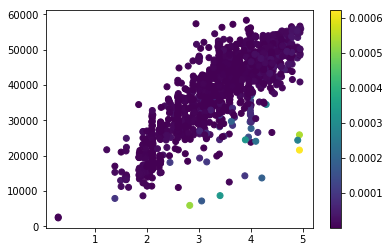

In [11]:
plt.scatter(for_plot['init_enr'], for_plot['bu'], c=for_plot['rmse'])
plt.colorbar()
plt.show()

[240, 706, 388, 615, 540, 469, 720, 369, 584, 505]


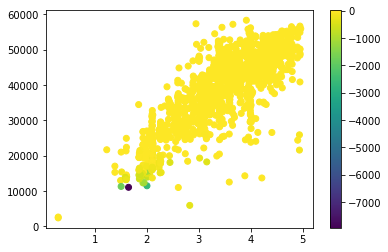

In [12]:
kill_indx = sorted(range(len(for_plot['rmpe'])), key=lambda i: for_plot['rmpe'][i])[:5]
kill_indx += sorted(range(len(for_plot['rmpe'])), key=lambda i: for_plot['rmpe'][i])[-5:]
new_list = [i for indx, i in enumerate(for_plot['rmpe']) if indx not in kill_indx]
x = [i for indx, i in enumerate(for_plot['init_enr']) if indx not in kill_indx]
y = [i for indx, i in enumerate(for_plot['bu']) if indx not in kill_indx]
print(kill_indx)
plt.scatter(x, y, c=new_list)
plt.colorbar()
plt.show()

## Error for all isotopes for single enrichment / burnup

In [13]:
eval_date_list =  list(rom_dict.keys())
import random
rand_indx = random.sample(range(1, len(eval_date_list)), 10)
rand_date_list = [eval_date_list[i] for i in rand_indx]
      


enr_bu_dict = {}
for i in rand_date_list:
    enr_bu_dict[i] = {}
    temp_df = df.loc[df['evaluation_date'] == i]
    enr_bu_dict[i]['enr'] = list(temp_df['init_enr'])[0]
    enr_bu_dict[i]['bu'] = list(temp_df['bu'])[0]
    
    enr_bu_dict[i]['err'] = {}
    for iso in iso_list:
        if iso == 'other':
            continue
        err = (rom_dict[i]['comp'][iso] - lump_dict[i]['comp'][iso]) / lump_dict[i]['comp'][iso]
        enr_bu_dict[i]['err'][iso] = err


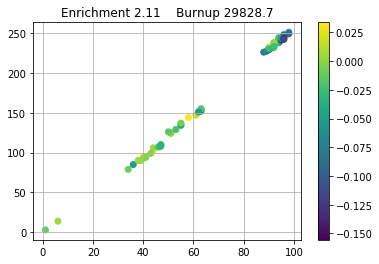

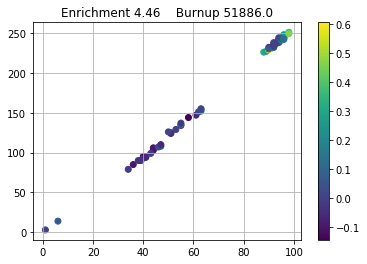

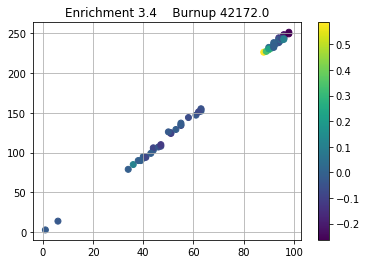

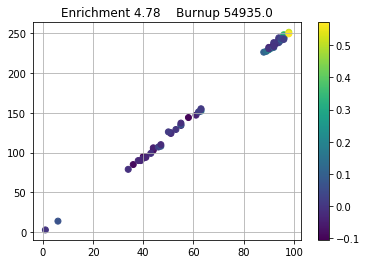

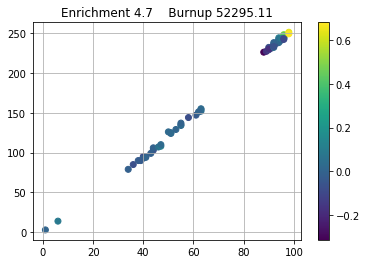

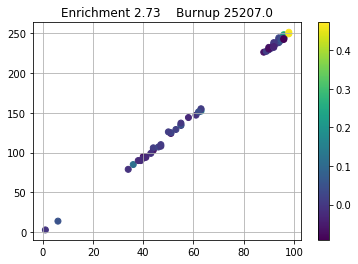

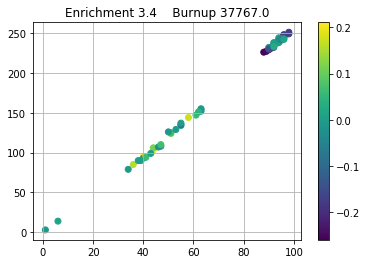

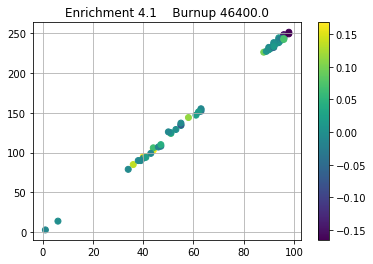

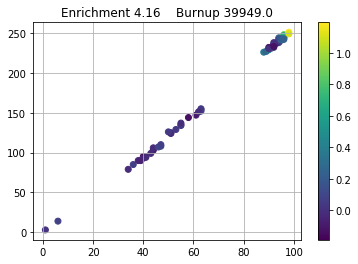

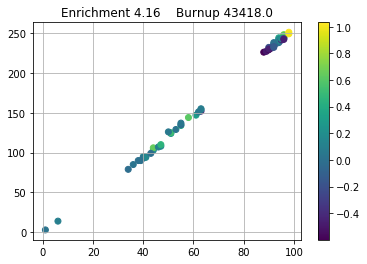

In [14]:
for date, val in enr_bu_dict.items():
    z = []
    a = []
    for iso in val['err']:
        z.append(nucname.zzzaaa(iso) // 1000)
        a.append(nucname.zzzaaa(iso) % 1000)
    plt.scatter(z, a, c=list(val['err'].values()))
    plt.colorbar()
    enr = round(float(val['enr']), 2) 
    bu = round(float(val['bu']), 2)
    plt.title('Enrichment ' + str(enr) + '    ' + 'Burnup ' + str(bu))
    plt.grid()
    plt.show()
    plt.close()

# Then we convert the assembly to `pyne` material, for decay and analysis

In [15]:
def attach_pyne_material(assem_dict):
    for key, value in assem_dict.items():
        pyne_mat = Material(value['comp'], value['mass'])
        assem_dict[key]['mat'] = pyne_mat
    return assem_dict

In [16]:
lump_dict = attach_pyne_material(lump_dict)
recipe_dict = attach_pyne_material(recipe_dict)
rom_dict = attach_pyne_material(rom_dict)

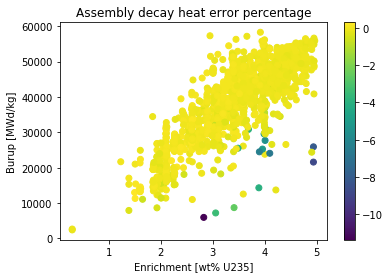

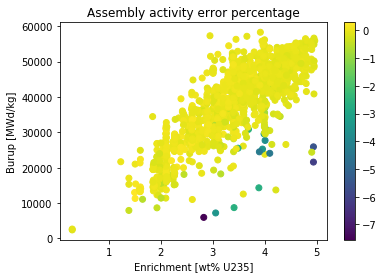

In [32]:
bu_list = []
enr_list = []
decay_heat_err_list = []
activity_err_list = []

# compare decay heat / activity error for each assemblys 

def get_err(one, two):
    tot = 0
    for key,val in one.items():
        if np.isnan(val) or np.isnan(two[key]):
           continue
        tot += (val - two[key])
    return tot / np.nansum(list(one.values()))

for key, val in lump_dict.items():
    bu_list.append(val['bu'])
    enr_list.append(val['init_enr'])
    model_mat = rom_dict[key]['mat']
    lump_mat = val['mat']
    decay_heat_err = get_err(lump_mat.decay_heat(), model_mat.decay_heat())
    decay_heat_err_list.append(decay_heat_err)
    activity_err = get_err(lump_mat.activity(), model_mat.activity())
    activity_err_list.append(activity_err)

    

plt.scatter(enr_list, bu_list, c=decay_heat_err_list)
plt.colorbar()
plt.xlabel('Enrichment [wt% U235]')
plt.ylabel('Burup [MWd/kg]')
plt.title('Assembly decay heat error percentage')
plt.show()
plt.close()


plt.scatter(enr_list, bu_list, c=activity_err_list)
plt.colorbar()
plt.xlabel('Enrichment [wt% U235]')
plt.ylabel('Burup [MWd/kg]')
plt.title('Assembly activity error percentage')
plt.show()
plt.close()


# Then we decay the assemblies to 2020:

In [48]:
def find_diff_time_secs(year, month, day, evaluation_date):
    # the UNF-ST&DARDS data format is YYYY-MM-DD
    ev_year = int(evaluation_date[:4])
    ev_month = int(evaluation_date[5:7])
    ev_day = int(evaluation_date[8:])
    
    dyear = 0
    dmonth = 0
    dday = day - ev_day
    if dday < 0:
        dmonth -= 1
        dday += 30
    dmonth += month - ev_month
    if dmonth < 0:
        dyear -= 1
        dmonth += 12
    dyear += year - ev_year
    if dyear < 0:
        raise ValueError('Cannot go back in time man')
    
    time_in_sec = dyear * (365 * 24 * 3600) + dmonth * (30 * 24 * 3600) + dday * (24 * 3600)
    return time_in_sec

In [49]:
def decay_assemblies(assem_dict):
    # just put the pyne materials in there, other categories are unnecessary
    decayed_dict = {}
    for key, value in assem_dict.items():
        # to 2020-07-01
        decay_time = find_diff_time_secs(2020, 7, 1, key)
        decayed_dict[key] = {}
        decayed_dict[key]['mass'] = assem_dict[key]['mass']
        decayed_dict[key]['mat'] = assem_dict[key]['mat'].decay(decay_time)
    return decayed_dict

In [50]:
decayed_lump_dict = decay_assemblies(lump_dict)
decayed_recipe_dict = decay_assemblies(recipe_dict)
decayed_rom_dict = decay_assemblies(rom_dict)

# Then we compare the metrics:

In [51]:
import math

def nansum(dictionary):
    summ = 0 
    for key, value in dictionary.items():
        # skip metastable isotopes
        if str(key)[-1] == '1':
            continue
        if not math.isnan(value):
             summ += value
    return summ

def decay_heatz(assem_dict, time=0):
    total_heat = 0
    for key, value in assem_dict.items():
        after = assem_dict[key]['mat'].decay(time)
        total_heat += nansum(after.decay_heat())
    return total_heat

def total_massz(assem_dict, time=0):
    total_mass = 0
    for key, value in assem_dict.items():
        after = assem_dict[key]['mat'].decay(time)
        total_mass += value['mass']
    return total_mass

def activityz(assem_dict, time=0):
    activity = 0
    for key, value in assem_dict.items():
        after = assem_dict[key]['mat'].decay(time)
        activity += nansum(after.activity())
    return activity

def isotopics(assem_dict, time=0):
    iso_dict = {}
    for key, value in assem_dict.items():
        for key2, value2 in value['mat'].mult_by_mass().items():
            if key2 not in iso_dict.keys():
                iso_dict[key2] = value2
            else:
                iso_dict[key2] += value2
    return iso_dict


In [52]:
post_lump = isotopics(decayed_lump_dict)
post_recipe = isotopics(decayed_recipe_dict)
post_rom = isotopics(decayed_rom_dict)

pre_lump = isotopics(lump_dict)
pre_recipe = isotopics(recipe_dict)
pre_rom = isotopics(rom_dict)

In [53]:
# check pu-239 amount
# total mass -> should be the same
print('UNIT: T')

print('\nPost-decay')
print(post_lump[942390000] * 1e-3) 
print(post_recipe[942390000] * 1e-3)
print(post_rom[942390000] * 1e-3)

print('\nPre-decay')
print(pre_lump[942390000] * 1e-3)
print(pre_recipe[942390000] * 1e-3)
print(pre_rom[942390000] * 1e-3)



UNIT: T

Post-decay
321.0212954045361
315.40008958238263
319.287537847114

Pre-decay
321.1966359237201
315.5771931239671
319.4620124255188


In [54]:
# check cs137 amount
print('CS 137')
print('UNIT: T')

print('\nPost-decay')
print(post_lump[551370000] * 1e-3) 
print(post_recipe[551370000] * 1e-3)
print(post_rom[551370000] * 1e-3)

print('\nPre-decay')
print(pre_lump[551370000] * 1e-3)
print(pre_recipe[551370000] * 1e-3)
print(pre_rom[551370000] * 1e-3)


CS 137
UNIT: T

Post-decay
40.72281301020515
38.858729558794444
40.291831512959874

Pre-decay
63.92299857756599
63.345825082133786
63.25333513439518


In [55]:
# check u235 amount
print('U235')
print('UNIT: T')

print('\nPost-decay')
print(post_lump[922350000] * 1e-3) 
print(post_recipe[922350000] * 1e-3)
print(post_rom[922350000] * 1e-3)

print('\nPre-decay')
print(pre_lump[922350000] * 1e-3)
print(pre_recipe[922350000] * 1e-3)
print(pre_rom[922350000] * 1e-3)

U235
UNIT: T

Post-decay
478.74660025800745
468.1169619950246
457.1060447621311

Pre-decay
478.5494787221699
467.917326580341
456.90937529784253


In [56]:
# total mass -> should be the same
print('UNIT: T')

print('\nPost-decay')
print(total_massz(decayed_lump_dict) * 1e-3) 
print(total_massz(decayed_recipe_dict) * 1e-3)
print(total_massz(decayed_rom_dict) * 1e-3)

print('\nPre-decay')
print(total_massz(lump_dict) * 1e-3)
print(total_massz(recipe_dict) * 1e-3)
print(total_massz(rom_dict) * 1e-3)


UNIT: T

Post-decay
45557.814055830066
45557.814055830066
45557.814055830066

Pre-decay
45557.814055830066
45557.814055830066
45557.814055830066


In [57]:
print('UNIT: MW')
print('\nPost-decay')
print(decay_heatz(decayed_lump_dict) * 1e3) 
print(decay_heatz(decayed_recipe_dict) * 1e3)
print(decay_heatz(decayed_rom_dict) * 1e3)

print('\nPre-decay')
print(decay_heatz(lump_dict)* 1e3)
print(decay_heatz(recipe_dict)* 1e3)
print(decay_heatz(rom_dict) * 1e3)


UNIT: MW

Post-decay
41.01552738443449
38.299017778586574
40.832005075319834

Pre-decay
193.59143433444106
177.28634375577658
192.00165833686222


In [58]:
print('UNIT: Bq')
print('\nPost-decay')
print(activityz(decayed_lump_dict) * 1e3)
print(activityz(decayed_recipe_dict)* 1e3)
print(activityz(decayed_rom_dict) * 1e3)

print('\nPre-decay')
print(activityz(lump_dict) * 1e3)
print(activityz(recipe_dict) * 1e3)
print(activityz(rom_dict) * 1e3)

UNIT: Bq

Post-decay
4.679869394599826e+20
4.406883629836051e+20
4.622942110702225e+20

Pre-decay
2.803975331153404e+21
2.5293263210595326e+21
2.746351904493114e+21


# Checking that our results match the data, we do a direct comparison between the decayed material using UNF-ST&DARDS and an Avg. Recipe

In [59]:
# lump the materials to one material to make this easier
def lump_dict_to_mat(assem_dict):
    out_mat = Material({'H1':1},1e-6)
    for key, val in assem_dict.items():
        out_mat = out_mat + assem_dict[key]['mat']
    return out_mat

In [60]:
decayed_lump_mat = lump_dict_to_mat(decayed_lump_dict)
decayed_recipe_mat = lump_dict_to_mat(decayed_recipe_dict)
decayed_rom_mat = lump_dict_to_mat(decayed_rom_dict)

In [61]:
def plot_decay_heat(mat, start_year, end_year, n_grid=100):
    heat_array = np.zeros(n_grid)
    time_array = np.linspace(0, ((end_year - start_year) * (3600 * 24 * 365)), n_grid)
    time_axis = np.linspace(start_year, end_year, n_grid)
    for index, time in enumerate(time_array):
        decayed = mat.decay(time)
        heat_array[index] = nansum(decayed.decay_heat())
    return time_axis, heat_array * 1e3

def plot_activity(mat, start_year, end_year, n_grid=100):
    heat_array = np.zeros(n_grid)
    time_array = np.linspace(0, ((end_year - start_year) * (3600 * 24 * 365)), n_grid)
    time_axis = np.linspace(start_year, end_year, n_grid)
    for index, time in enumerate(time_array):
        decayed = mat.decay(time)
        heat_array[index] = nansum(decayed.activity())
    return time_axis, heat_array * 1e3

def get_fissile_eq(mat, thermal=False):
    # from plutonium fuel - an assessment (NEA)
    eq = 0
    if thermal:
        eq += mat.mult_by_mass()[922350000] * 0.8
        eq += mat.mult_by_mass()[942380000] * (-1.0)
        eq += mat.mult_by_mass()[942390000] * (1.0)
        eq += mat.mult_by_mass()[942400000] * (-0.4)
        eq += mat.mult_by_mass()[942410000] * (1.3)
        eq += mat.mult_by_mass()[942420000] * (-1.4)
        eq += mat.mult_by_mass()[952410000] * (-2.2)
    else:
        # fast spectrum (super-phenix)
        eq += mat.mult_by_mass()[922350000] * 0.8
        eq += mat.mult_by_mass()[942380000] * (0.44)
        eq += mat.mult_by_mass()[942390000] * (1.0)
        eq += mat.mult_by_mass()[942400000] * (0.14)
        eq += mat.mult_by_mass()[942410000] * (1.5)
        eq += mat.mult_by_mass()[942420000] * (0.037)
        eq += mat.mult_by_mass()[952410000] * (-0.33)
    return eq

def plot_fissile_quality(mat, start_year, end_year, n_grid=100):
    qual_array = np.zeros(n_grid)
    time_array = np.linspace(0, ((end_year - start_year) * (3600 * 24 * 365)), n_grid)
    time_axis = np.linspace(start_year, end_year, n_grid)
    for index, time in enumerate(time_array):
        decayed = mat.decay(time)
        qual_array[index] = get_fissile_eq(decayed)
    return time_axis, qual_array

In [76]:
# decay heat at discrete times

# to 2100
print('At 2100:')
t_to_2100 = 80 * (3600 * 24 * 365)
acc = nansum(decayed_lump_mat.decay(t_to_2100).decay_heat())
rec = nansum(decayed_rom_mat.decay(t_to_2100).decay_heat())
print(acc)
print(rec)
print('err %')
print((acc-rec)/acc * 100)
print('\n')

print('At 3100')
t_to_3100 = 1080 * (3600 * 24 * 365)
acc = nansum(decayed_lump_mat.decay(t_to_3100).decay_heat())
rec = nansum(decayed_rom_mat.decay(t_to_3100).decay_heat())
print(acc)
print(rec)
print('err %')
print((acc-rec)/acc * 100)
print('\n')


At 2100:
0.01643763667395272
0.016399745245736147
err %
0.23051627778471806


At 3100
0.003140784749994112
0.003138108386524299
err %
0.08521320889049654




In [77]:
# activity at discrete times
from decimal import Decimal

# to 2100

t_to_2100 = 80 * (3600 * 24 * 365)
acc = nansum(decayed_lump_mat.decay(t_to_2100).activity())
rec = nansum(decayed_rom_mat.decay(t_to_2100).activity())
print(acc)
print(rec)
print('err %')
print((acc-rec)/acc * 100)
print('\n')


t_to_3100 = 1080 * (3600 * 24 * 365)
acc = nansum(decayed_lump_mat.decay(t_to_3100).activity())
rec = nansum(decayed_rom_mat.decay(t_to_3100).activity())
print('%.2E' % Decimal(acc))
print('%.2E' % Decimal(rec))
print('err %')
print((acc-rec)/acc * 100)
print('\n')


6.398804836189758e+16
6.3289935315451224e+16
err %
1.091005374156808


3.68E+15
3.68E+15
err %
0.061188792311418175




In [78]:
time_acc, heat_acc = plot_decay_heat(decayed_lump_mat, 2020, 3100)
time_rom, heat_rom = plot_decay_heat(decayed_rom_mat, 2020, 3100)
time_rec, heat_rec = plot_decay_heat(decayed_recipe_mat, 2020, 3100)

time_acc, act_acc = plot_activity(decayed_lump_mat, 2020, 3100)
time_rom, act_rom = plot_activity(decayed_rom_mat, 2020, 3100)
time_rec, act_rec = plot_activity(decayed_recipe_mat, 2020, 3100)

time_acc, fiss_acc = plot_fissile_quality(decayed_lump_mat, 2020, 3100)
time_rom, fiss_rom = plot_fissile_quality(decayed_rom_mat, 2020, 3100)
time_rec, fiss_rec = plot_fissile_quality(decayed_recipe_mat, 2020, 3100)

In [79]:
err_heat = (heat_acc - heat_rec) / heat_acc * 100
err_act = (act_acc - act_rec) / act_acc * 100
err_heat_rom = (heat_acc - heat_rom) / heat_acc * 100
err_act_rom = (act_acc - act_rom) / act_acc * 100

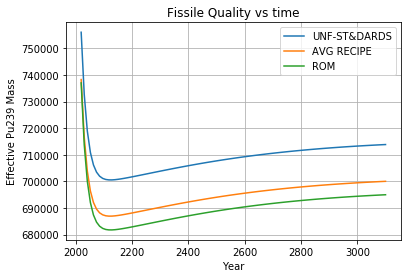

<function matplotlib.pyplot.close(fig=None)>

In [80]:
plt.plot(time_acc, fiss_acc, label='UNF-ST&DARDS')
plt.plot(time_rec, fiss_rec, label='AVG RECIPE')
plt.plot(time_rec, fiss_rom, label='ROM')

plt.title('Fissile Quality vs time')
plt.xlabel('Year')
plt.ylabel('Effective Pu239 Mass')
plt.legend()
plt.grid()
plt.savefig('./images/fiss.png', format='png')
plt.show()
plt.close

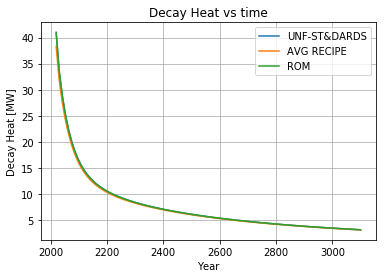

<function matplotlib.pyplot.close(fig=None)>

In [81]:
plt.plot(time_acc, heat_acc, label='UNF-ST&DARDS')
plt.plot(time_rec, heat_rec, label='AVG RECIPE')
plt.plot(time_rec, heat_rom, label='ROM')

plt.title('Decay Heat vs time')
plt.xlabel('Year')
plt.ylabel('Decay Heat [MW]')
plt.legend()
plt.grid()
plt.savefig('./images/heat.png', format='png')
plt.show()
plt.close

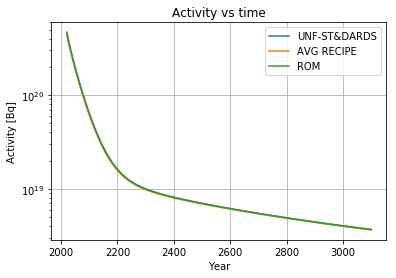

<function matplotlib.pyplot.close(fig=None)>

In [82]:
plt.semilogy(time_acc, act_acc, label='UNF-ST&DARDS')
plt.semilogy(time_rec, act_rec, label='AVG RECIPE')
plt.semilogy(time_rom, act_rom, label='ROM')
plt.title('Activity vs time')
plt.xlabel('Year')
plt.ylabel('Activity [Bq]')
plt.legend()
plt.grid()
plt.savefig('./images/activity.png', format='png')
plt.show()
plt.close

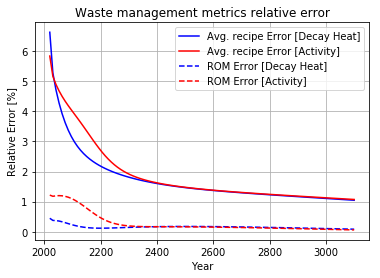

In [83]:
plt.plot(time_acc, err_heat, label='Avg. recipe Error [Decay Heat]', color='b')
plt.plot(time_acc, err_act, label='Avg. recipe Error [Activity]', color='r')

plt.plot(time_acc, err_heat_rom, label='ROM Error [Decay Heat]', color='b', linestyle='--')
plt.plot(time_acc, err_act_rom, label='ROM Error [Activity]', color='r', linestyle='--')

plt.xlabel('Year')
plt.ylabel('Relative Error [%]')
plt.legend()
plt.grid()
plt.title('Waste management metrics relative error')
plt.tight_layout
plt.savefig('./images/ha_err.png', format='png')
plt.show()
plt.close()

# Compare isotopic differences

In [90]:
def compare_isotope(acc_mat, rec_mat, isotope_list, rel_err=False):
    # convert to canonical / pyne-standard form
    isotope_list = [nucname.id(x) for x in isotope_list]
    iso_diff_dict = {}
    for iso in isotope_list:
        acc_qty = acc_mat.mult_by_mass()[iso]
        rec_qty = rec_mat.mult_by_mass()[iso]
        if rel_err:
            iso_diff_dict[nucname.name(iso)] = (acc_qty - rec_qty) / acc_qty * 100
        else:
            iso_diff_dict[nucname.name(iso)] = (acc_qty - rec_qty) * 1e-3
    return iso_diff_dict

def compare_element(acc_mat, rec_mat, zz_list, rel_err=False):
    el_diff_dict = {}
    for zz in zz_list:
        acc_qty = 0
        rec_qty = 0
        for key, val in acc_mat.mult_by_mass().items():
            if key // 10000000 == zz:
                acc_qty += acc_mat.mult_by_mass()[key]
                rec_qty += rec_mat.mult_by_mass()[key]
        if rel_err:
            el_diff_dict[zz] = (acc_qty - rec_qty) / acc_qty * 100
        else:
            el_diff_dict[zz] = acc_qty - rec_qty
    return el_diff_dict

def get_fissile_eq(mat, thermal=False):
    # from plutonium fuel - an assessment (NEA)
    eq = 0
    if thermal:
        eq += mat.mult_by_mass()[922350000] * 0.8
        eq += mat.mult_by_mass()[942380000] * (-1.0)
        eq += mat.mult_by_mass()[942390000] * (1.0)
        eq += mat.mult_by_mass()[942400000] * (-0.4)
        eq += mat.mult_by_mass()[942410000] * (1.3)
        eq += mat.mult_by_mass()[942420000] * (-1.4)
        eq += mat.mult_by_mass()[952410000] * (-2.2)
    else:
        # fast spectrum (super-phenix)
        eq += mat.mult_by_mass()[922350000] * 0.8
        eq += mat.mult_by_mass()[942380000] * (0.44)
        eq += mat.mult_by_mass()[942390000] * (1.0)
        eq += mat.mult_by_mass()[942400000] * (0.14)
        eq += mat.mult_by_mass()[942410000] * (1.5)
        eq += mat.mult_by_mass()[942420000] * (0.037)
        eq += mat.mult_by_mass()[952410000] * (-0.33)
    return eq

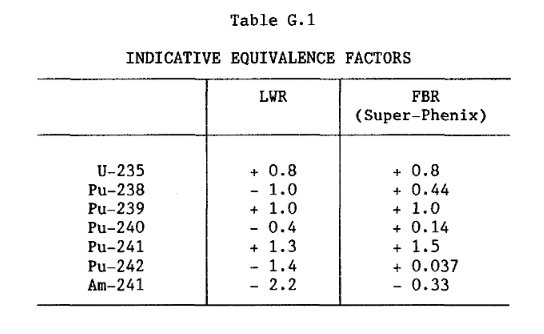

In [91]:
# Pu equiv factor from plutonium fuels (NEA)
from IPython.display import Image
Image('./images/pu_equiv.png')

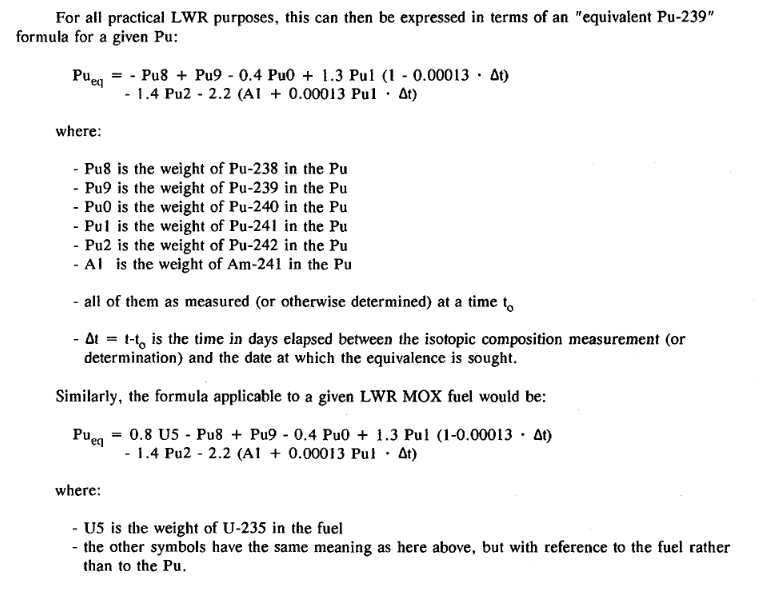

In [92]:
Image('./images/pu_equiv_eq.png')

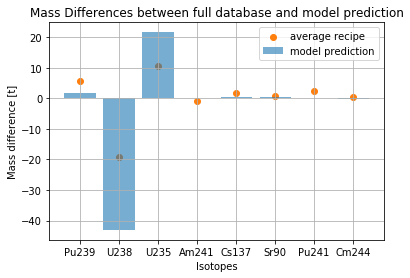

In [93]:
iso_list = ['Pu239', 'U238', 'U235', 'Am241', 'Cs137', 'Sr90', 'Pu241', 'Cm244']
iso_diff_dict = compare_isotope(decayed_lump_mat, decayed_rom_mat, iso_list)
iso_diff_dict_recipe = compare_isotope(decayed_lump_mat, decayed_recipe_mat, iso_list)
plt.bar(iso_diff_dict.keys(), iso_diff_dict.values(), alpha=0.6, label='model prediction')
plt.scatter(iso_diff_dict_recipe.keys(), iso_diff_dict_recipe.values(), label='average recipe')

plt.grid()
plt.ylabel('Mass difference [t]')
plt.xlabel('Isotopes')
plt.legend()
plt.title('Mass Differences between full database and model prediction')
plt.savefig('./images/iso_mass.png', format='png')
plt.show()
plt.close()

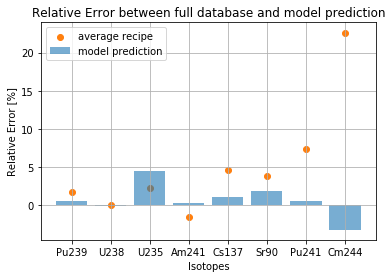

In [94]:
iso_list = ['Pu239', 'U238', 'U235', 'Am241', 'Cs137', 'Sr90', 'Pu241', 'Cm244']
iso_diff_dict = compare_isotope(decayed_lump_mat, decayed_rom_mat, iso_list, rel_err=True)
iso_diff_dict_recipe = compare_isotope(decayed_lump_mat, decayed_recipe_mat, iso_list, rel_err=True)

plt.bar(iso_diff_dict.keys(), iso_diff_dict.values(), alpha=0.6, label='model prediction')
plt.scatter(iso_diff_dict_recipe.keys(), iso_diff_dict_recipe.values(), label='average recipe')
plt.grid()
plt.ylabel('Relative Error [%]')
plt.xlabel('Isotopes')
plt.legend()
plt.title('Relative Error between full database and model prediction')
plt.savefig('./images/iso_rel.png', format='png')
plt.show()
plt.close()

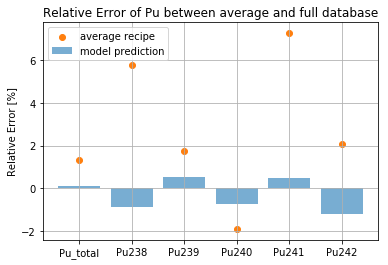

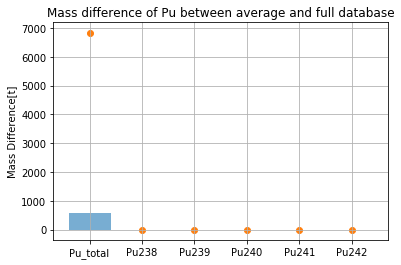

In [95]:
zz_list = [94]
el_diff_dict = compare_element(decayed_lump_mat, decayed_rom_mat, zz_list, rel_err=True)
el_diff_dict_recipe = compare_element(decayed_lump_mat, decayed_recipe_mat,
                                      zz_list, rel_err=True)

#plt.bar(['Pu Total'], [el_diff_dict[94]], alpha=0.6, label='model prediction')
#plt.scatter(['Pu Total'], [el_diff_dict_recipe[94]], label='average recipe')

iso_list = ['Pu238', 'Pu239', 'Pu240', 'Pu241', 'Pu242']

iso_diff_dict = compare_isotope(decayed_lump_mat, decayed_rom_mat, iso_list, rel_err=True)
iso_diff_dict_recipe = compare_isotope(decayed_lump_mat, decayed_recipe_mat,
                                       iso_list, rel_err=True)

plt.bar(['Pu_total'] + iso_list, [el_diff_dict[94]] + list(iso_diff_dict.values()), alpha=0.6, label='model prediction')
plt.scatter(['Pu_total'] + iso_list, [el_diff_dict_recipe[94]] + list(iso_diff_dict_recipe.values()), label='average recipe')
plt.grid()
plt.legend()
plt.ylabel('Relative Error [%]')
plt.title('Relative Error of Pu between average and full database')
plt.savefig('./images/pu_rel.png', format='png')
plt.show()
plt.close()

# actual mass difference
zz_list = [94]
el_diff_dict = compare_element(decayed_lump_mat, decayed_rom_mat, zz_list, rel_err=False)
el_diff_dict_recipe = compare_element(decayed_lump_mat, decayed_recipe_mat,
                                      zz_list, rel_err=False)
iso_list = ['Pu238', 'Pu239', 'Pu240', 'Pu241', 'Pu242']

iso_diff_dict = compare_isotope(decayed_lump_mat, decayed_rom_mat, iso_list, rel_err=False)
iso_diff_dict_recipe = compare_isotope(decayed_lump_mat, decayed_recipe_mat,
                                       iso_list, rel_err=False)

plt.bar(['Pu_total'] + iso_list, [el_diff_dict[94]] + list(iso_diff_dict.values()), alpha=0.6, label='model prediction')
plt.scatter(['Pu_total'] + iso_list, [el_diff_dict_recipe[94]] + list(iso_diff_dict_recipe.values()), label='average recipe')
plt.bar(iso_diff_dict.keys(), np.array(list(iso_diff_dict.values())))
plt.grid()
plt.ylabel('Mass Difference[t]')
plt.title('Mass difference of Pu between average and full database')
plt.savefig('./images/pu_mass.png', format='png')
plt.show()
plt.close()

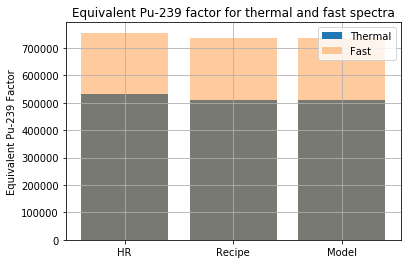

0.5306152618629704
0.5122338391135678
0.7560793181868616
0.7382826860486739


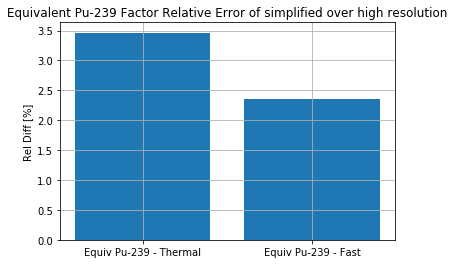

3.464171513813246
2.3538049130698866


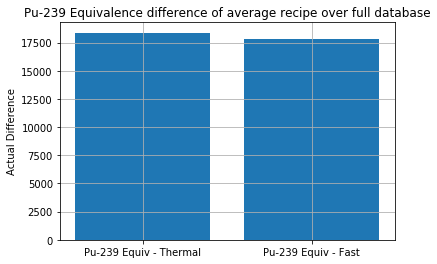

In [101]:
# eff pu241 for thermal and fast


acc_eq_thermal = get_fissile_eq(decayed_lump_mat, True)
acc_eq_fast = get_fissile_eq(decayed_lump_mat, False)
model_eq_thermal = get_fissile_eq(decayed_rom_mat, True)
model_eq_fast = get_fissile_eq(decayed_rom_mat, False)
rec_eq_thermal = get_fissile_eq(decayed_recipe_mat, True)
rec_eq_fast = get_fissile_eq(decayed_recipe_mat, False)

rel_err_thermal = (acc_eq_thermal - rec_eq_thermal) / acc_eq_thermal * 100
rel_err_fast = (acc_eq_fast - rec_eq_fast) / acc_eq_fast * 100


plt.bar(['HR', 'Recipe', 'Model'],
        [acc_eq_thermal, rec_eq_thermal, model_eq_thermal],
        label='Thermal')
plt.bar(['HR', 'Recipe', 'Model'],
        [acc_eq_fast, rec_eq_fast, model_eq_fast],
        label='Fast', alpha=0.4)
plt.grid()
plt.ylabel('Equivalent Pu-239 Factor')
plt.legend()
plt.title('Equivalent Pu-239 factor for thermal and fast spectra')
plt.savefig('./images/equiv_all.png', format='png')
plt.show()
plt.close()

print(acc_eq_thermal *1e-6)
print(rec_eq_thermal*1e-6)
print(acc_eq_fast*1e-6)
print(rec_eq_fast*1e-6)

plt.bar(['Equiv Pu-239 - Thermal', 'Equiv Pu-239 - Fast'], [rel_err_thermal, rel_err_fast])
plt.grid()
plt.ylabel('Rel Diff [%]')
plt.title('Equivalent Pu-239 Factor Relative Error of simplified over high resolution')
plt.savefig('./images/equiv_rel.png', format='png')
plt.show()
plt.close()

print(rel_err_thermal)
print(rel_err_fast)

plt.bar(['Pu-239 Equiv - Thermal', 'Pu-239 Equiv - Fast'], [acc_eq_thermal - rec_eq_thermal, acc_eq_fast - rec_eq_fast])
plt.grid()
plt.ylabel('Actual Difference')
plt.title('Pu-239 Equivalence difference of average recipe over full database')
plt.show()
plt.close()